### Connect to Drive

In [57]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [58]:
%cd /gdrive/My Drive/Challenge2

/gdrive/My Drive/Challenge2


### Import libraries

In [59]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [60]:
# Random seed for reproducibility
seed = 40

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)
#### Human Activity Recognition

Load and clean the dataset

In [61]:
cd training_dataset_homework2/

/gdrive/My Drive/Challenge2/training_dataset_homework2


In [62]:
x_train= np.load("x_train.npy")
y_train= np.load("y_train.npy")

In [63]:
x_train.shape

(2429, 36, 6)

In [64]:
y_train.shape

(2429,)

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=seed, test_size=.1)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2186, 36, 6), (2186,), (243, 36, 6), (243,))

### Preprocessing

In [66]:
# Map activities to integers
label_mapping = {
     "Wish": 0,
      "Another": 1,
"Comfortably": 2,
"Money": 3,
"Breathe":4,
 "Time":5,
 "Brain":6,
 "Echoes":7,
"Wearing":8,
"Sorrow":9,
"Hey":10,
 "Shine":11
}

In [67]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
x_train.shape, y_train.shape, y_test.shape, y_test.shape

((2186, 36, 6), (2186, 12), (243, 12), (243, 12))

In [68]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 64
epochs = 200

In [75]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(512, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(512))(bilstm)
    dropout = tfkl.Dropout(.7, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [76]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_10 (Bidirecti  (None, 36, 1024)         2125824   
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 1024)             6295552   
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_12 (Dense)            (None, 128)               131200    
                                                                 
 dense_13 (Dense)            (None, 12)                1548  

In [77]:
# Train the model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 164s 5s/step - loss: 1.6971 - accuracy: 0.4321 - val_loss: 1.3871 - val_accuracy: 0.5342 - lr: 0.0010
Epoch 2/200
31/31 [==============================] - 144s 5s/step - loss: 1.2293 - accuracy: 0.5765 - val_loss: 1.1668 - val_accuracy: 0.6347 - lr: 0.0010
Epoch 3/200
31/31 [==============================] - 146s 5s/step - loss: 1.0368 - accuracy: 0.6370 - val_loss: 1.2857 - val_accuracy: 0.5890 - lr: 0.0010
Epoch 4/200
31/31 [==============================] - 149s 5s/step - loss: 0.9515 - accuracy: 0.6660 - val_loss: 1.1490 - val_accuracy: 0.5616 - lr: 0.0010
Epoch 5/200
31/31 [==============================] - 147s 5s/step - loss: 0.8335 - accuracy: 0.7117 - val_loss: 1.0877 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 6/200
31/31 [==============================] - 147s 5s/step - loss: 0.7366 - accuracy: 0.7458 - val_loss: 1.1443 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 7/200
31/31 [==============================] - 150s 5s/step - lo

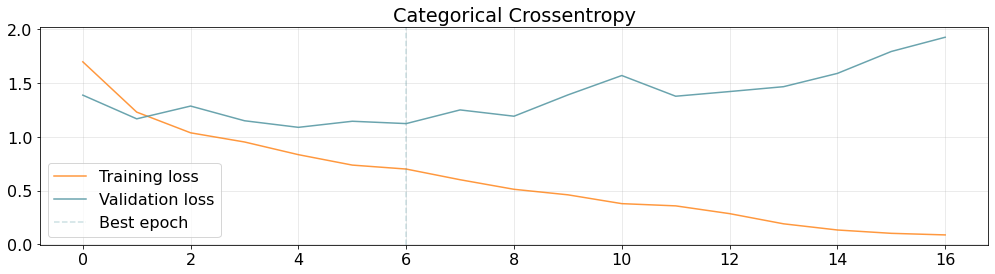

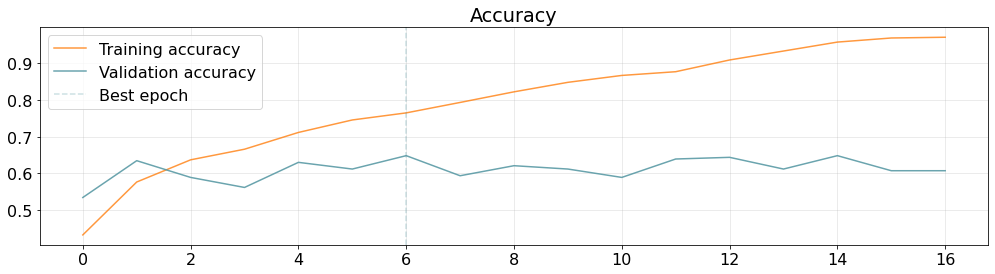

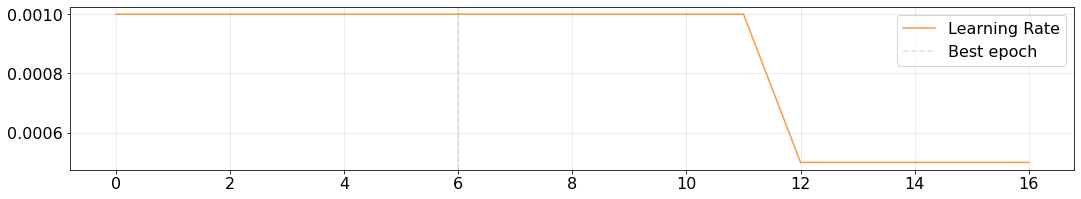

In [78]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [79]:
model.save('BiLSTM')
# model = tfk.models.load_model('BiLSTM')

In [80]:
# Predict the test set with the BiLSTM
predictions = model.predict(x_test)
predictions.shape

8/8 [==============================] - 7s 610ms/step


(243, 12)

Accuracy: 0.6173
Precision: 0.4479
Recall: 0.4239
F1: 0.4315


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


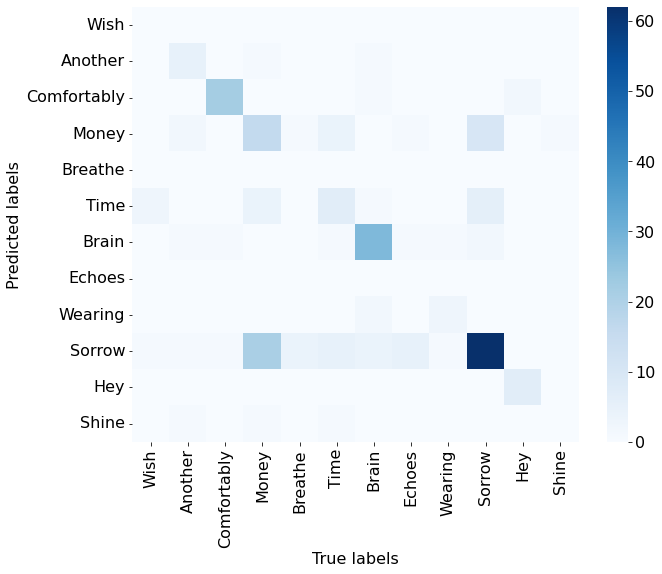

In [81]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()